In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit

exp=np.exp
def alpha_m (V):
    return  -0.025*(V+40.)/( exp(-(V+40)/10) - 1.0 )
def beta_m(V):
    return exp(-(V+65)/18)
def mNa_inf(V):
    return alpha_m(V) / (alpha_m(V) + beta_m(V))
def tau_mNa(V):
    return 1 / (alpha_m(V) + beta_m(V))/5
def alpha_h(V):
    return 0.0175*exp(-(V+65)/20)
def beta_h(V):
    return 0.25/(1.0 + exp(-(V+35)/10) )
def hNa_inf(V):
    return alpha_h(V) / (alpha_h(V) + beta_h(V))
def tau_hNa (V):
    return 1 / (alpha_h(V) + beta_h(V))/5
Kdshift=10.0

def alpha_mKd(V):
    return 0.0025*(V+55.)/(1. - exp(-(V+55.)/10.))
                           
beta_mKd = lambda V: 0.03125*exp(-(V+65.)/80.)
mKd_inf = lambda V: alpha_mKd(V-Kdshift) / (alpha_mKd(V-Kdshift) + beta_mKd(V-Kdshift))
tau_mKd = lambda V: 1 / (alpha_mKd(V-Kdshift) + beta_mKd(V-Kdshift))/5 

mA_inf = lambda V: 1/(1+exp(-(V+90)/8.5))
tau_mA = lambda V: 0.37 + 1/(exp((V+35.82)/19.697)+exp((V+79.69)/-12.7))/5 
hA_inf = lambda V: 1/(1+exp((V+78)/6))

def tau_hA(V): # Inactivation time-constant
    if (V < -63):
        tau_hA = 1/(exp((V+46.05)/5)+exp((V+238.4)/-37.45))
    else:
        tau_hA = 19
    return tau_hA/5

mKir_inf = lambda V: 1/(1+exp((V+97.9+10)/9.7))

# T-type Ca-current (mt=activation variable, ht=inactivation variable)
mt_inf = lambda V: 1/(1+exp(-(V+57)/6.2)) # Activation function
tau_mt = lambda V: 0.612 + 1/(exp(-(V+131.6)/16.7)+exp((V+16.8)/18.2)) # Activation time-constant
ht_inf = lambda V:1/(1+exp((V+81)/4.03)) # Inactivation function

def tau_ht(V): # Inactivation time-constant
    if (V < -80):
        tau_ht = exp((V+467)/66.6)
    else:
        tau_ht = (exp(-(V+21.88)/10.2)+28)
    return tau_ht


# L-type Ca-current (mL=activation variable)
mL_inf = lambda V:1/(1+exp(-(V+55.)/3)) # Activation function
tau_mL = lambda V: (72*exp(-(V+45.)**2/400)+6.) # Activation time-constant

# H-current (mH=activation variable)
alpha_mH = lambda V: exp(-14.59-(0.086*V))
beta_mH = lambda V: exp(-1.87+(0.0701*V))
mH_inf = lambda V: alpha_mH(V) /(alpha_mH(V) + beta_mH(V)) # Activation function
tau_mH = lambda V: 1/(alpha_mH(V) + beta_mH(V)) # Activation time-constant


In [6]:
heaviside =lambda t:(1+np.sign(t))/2 
pulse =lambda t,ti,tf : heaviside(t-ti)-heaviside(t-tf)
sin=np.sin
pi=np.pi

In [7]:

def HM_ODE(t,u):
    # Parameters
    Iapp=p[0] # Amplitude of constant applied current
    I1=p[1] # Amplitude of first step input
    I2=p[2] # Amplitude of second step input
    ti1=p[3] # Starting time of first step input
    tf1=p[4] # Ending time of first step input
    ti2=p[5] # Starting time of second step input
    tf2=p[6] # Ending time of second step input
    gT=p[7] # T-type calcium current maximal conductance
    gKd=p[8]  # Delayed-rectifier potassium current maximal conductance
    gH=p[9] # H-current maximal conductance
    gNa=p[10] # Sodium current maximal conductance
    gA=p[11] # A-type potassium current maximal conductance
    gKir=p[12]  # Inward-rectifier potassium current maximal conductance
    gLeak=p[13] # Leak current maximal conductance
    gL=p[14] # L-type calcium current maximal conductance
    gKCa=p[15] # Calcium-activated potassium current maximal conductance
    C=p[16] # Membrane capacitance
    taunoise=p[18] # Cutoff frequency for low-pass filtered Gaussian noise
    Ain=p[19] # Amplitude of sinusoïdal inut
    Win=p[20] # Frequency of  sinusoïdal inut

    # Variables
    V=u[0] # Membrane potential
    mNa=u[1] # Sodium current activation
    hNa=u[2] # Sodium current inactivation
    mH=u[3] # H current activation
    mt=u[4] # T-type calcium current activation
    ht=u[5] # T-type calcium current inactivation
    mA=u[6] # A-type potassium current activation
    hA=u[7] # A-type potassium current inactivation
    mKd=u[8] # Delayed-rectifier potassium current activation
    mL=u[9] # L-type calcium current activation
    Ca=u[10] # Intracellular calcium concentration
    noise=u[11] # Input noise

    # ODEs
    du1=1/C*(- gNa*mNa**3*hNa*(V-VNa) - gH*mH*(V-VH) - gT*mt**2*ht*(V-VCa) - gA*mA**4*hA*(V-VK) - gKd*mKd**4*(V-VK) -
                gKir*mKir_inf(V)*(V-VK) - gLeak*(V-Vleak)- gL*mL*(V-VCa) - gKCa*(Ca/(15.0+Ca))**4*(V-VK) +
                Iapp + I1*pulse(t,ti1,tf1) + I2*pulse(t,ti2,tf2) + noise + Ain*sin(2*pi*Win*t)) # Voltage equation
    du2=1/tau_mNa(V)*(-mNa+mNa_inf(V)) # gating equation
    du3=1/tau_hNa(V)*(-hNa+hNa_inf(V))
    du4=1/tau_mH(V)*(-mH+mH_inf(V))
    du5=1/tau_mt(V)*(-mt+mt_inf(V))
    du6=1/tau_ht(V)*(-ht+ht_inf(V))
    du7=1/tau_mA(V)*(-mA+mA_inf(V))
    du8=1/tau_hA(V)*(-hA+hA_inf(V))
    du9=1/tau_mKd(V)*(-mKd+mKd_inf(V))
    du10=1/tau_mL(V)*(-mL+mL_inf(V))
    du11=(-0.1*(gL*mL*(V-VCa))-0.01*Ca)/4 # Variation of intracellular calcium concentration
    du12=-noise/taunoise # Noise equation
    
    return [du1,du2,du3,du4,du5,du6,du7,du8,du9,du10,du11,du12]

In [8]:

def  OB_ODE(t,u):
    
    it=iter(u)
    dinamics,Theta,phi,P,u_sys=[[next(it) for _ in range(size)] for size in variable_size]
    
    V,mNa,hNa,mH,mt,ht,mA,hA,mKd,mL,Ca,noise=dinamics
    
    P=np.array(P).reshape([num_phi,num_phi])
    Theta=np.array(Theta)
    phi=np.array(phi)
    
    obesV=u_sys[0]
    
    
    Iapp=p[0] # Amplitude of constant applied current
    I1=p[1] # Amplitude of first step input
    I2=p[2] # Amplitude of second step input
    ti1=p[3] # Starting time of first step input
    tf1=p[4] # Ending time of first step input
    ti2=p[5] # Starting time of second step input
    tf2=p[6] # Ending time of second step input
    gT=p[7] # T-type calcium current maximal conductance
    gKd=p[8]  # Delayed-rectifier potassium current maximal conductance
    gH=p[9] # H-current maximal conductance
    gNa=p[10] # Sodium current maximal conductance
    gA=p[11] # A-type potassium current maximal conductance
    gKir=p[12]  # Inward-rectifier potassium current maximal conductance
    gLeak=p[13] # Leak current maximal conductance
    gL=p[14] # L-type calcium current maximal conductance
    gKCa=p[15] # Calcium-activated potassium current maximal conductance
    C=p[16] # Membrane capacitance
    taunoise=p[18] # Cutoff frequency for low-pass filtered Gaussian noise
    Ain=p[19] # Amplitude of sinusoïdal inut
    Win=p[20] # Frequency of  sinusoïdal inut
    
    
    PHI0= -mNa**3*hNa*(obesV-VNa) 
    PHI1= -mH*(obesV-VH)
    PHI2= -mt**2*ht*(obesV-VCa)
    PHI3= -mA**4*hA*(obesV-VK)
    PHI4= - mKd**4*(obesV-VK)
    PHI5= -mKir_inf(obesV)*(obesV-VK)
    PHI6= -(obesV-Vleak)
    PHI7= -mL*(obesV-VCa)
    PHI8= -(Ca/(15.0+Ca))**4*(obesV-VK)
    PHI9= Iapp + I1*pulse(t,ti1,tf1) + I2*pulse(t,ti2,tf2)+ Ain*sin(2*pi*Win*t)
    
    
    PHI= np.array([PHI0,PHI1,PHI2,PHI3,PHI4,PHI5,PHI6,PHI7,PHI8])
    
    #ODEs
    
    du1=1/C*(np.dot(PHI,Theta) + PHI9)+ gamma*(obesV-V)+gamma*np.dot(np.dot(phi,P),phi)*(obesV-V)# Voltage equation
    
    du2=1/tau_mNa(obesV)*(-mNa+mNa_inf(obesV)) # gating equation
    du3=1/tau_hNa(obesV)*(-hNa+hNa_inf(obesV))
    du4=1/tau_mH(obesV)*(-mH+mH_inf(obesV))
    du5=1/tau_mt(obesV)*(-mt+mt_inf(obesV))
    du6=1/tau_ht(obesV)*(-ht+ht_inf(obesV))
    du7=1/tau_mA(obesV)*(-mA+mA_inf(obesV))
    du8=1/tau_hA(obesV)*(-hA+hA_inf(obesV))
    du9=1/tau_mKd(obesV)*(-mKd+mKd_inf(obesV))
    du10=1/tau_mL(obesV)*(-mL+mL_inf(obesV))
    du11=(-0.1*(gL*mL*(obesV-VCa))-0.01*Ca)/4 # Variation of intracellular calcium concentration
    du12=-noise/taunoise # Noise equation
    
    du13=gamma*np.dot(P,phi)*(obesV-V)
    du14=-gamma*phi+PHI
    du15=alpha*P-np.dot(np.dot(P,np.outer(phi,phi)),P)
    
    du16=HM_ODE(t,u_sys)
    
    
    return ([[du1,du2,du3,du4,du5,du6,du7,du8,du9,du10,du11,du12],du13.tolist(),du14.tolist(),du15.flatten().tolist(),du16])

def  OB_ODE2(t,u):
    a,b,c,d,e= OB_ODE(t,u)
    out=[*a,*b,*c,*d,*e]
    
    if np.isnan(out).any():
        raise ValueError('nan',out,'place of nan:',np.argwhere(np.isnan(out)))
    elif np.isinf(out).any():
        raise ValueError('inf')
        
    return (out)
    

In [9]:
num_dinamics=12
num_Theta=9
num_phi=num_Theta
num_p=num_Theta**2
num_u_sys=12
variable_size=[num_dinamics,num_Theta,num_phi,num_p,num_u_sys]


In [10]:
from scipy.integrate import solve_ivp
## Simulation of the model in current-clamp mode

## Definition of reversal potential values. 
VNa = 45.; # Sodium reversal potential
VCa = 120.; # Calcium reversal potential
VK = -90.; # Potassium reversal potential
VH= -43.; # Reversal potential for the H-current (permeable to both sodium and potassium ions)
Vleak = -55.; # Reversal potential of leak channels

## Definition of membrane capacitance and maximal conductance values. 
C=0.1; # Membrane capacitance
gLeak=0.1; # Leak current maximal conductance

gNa=120.; # Sodium current maximal conductance 120
gKd=80; # Delayed-rectifier potassium current maximal conductance 80
gT=0; # T-type calcium current maximal conductance 2.
gH=0; # H-current maximal conductance 0.1
gL=0.4; # L-type calcium current maximal conductance 0.4
gKCa=2.; # Calcium-activated potassium current maximal conductance 2.
gA=0.; # A-type potassium current maximal conductance
gKir=0.; # Inward-rectifier potassium current maximal conductance

## Definition of simulation time.
Tfinal=2200.0
tspan=[0.0,Tfinal]

## Input current defition
# Constant current
Iapp=-1

# Current pulses
I1=0. # Amplitude of first pulse
ti1=100 # Starting time of first pulse
tf1=103 # Ending time of first pulse
I2=0. # Amplitude of second pulse
ti2=200 # Starting time of second pulse
tf2=203 # Ending time of first pulse

# Sinusoidal input
Ain=0.0 # Amplitude
Win=0.0 # Frequency

# Input noise
NoiseIN=0. # Amplitude
TauNoise=2.0 # Cut-off frequency

## Current-clamp experiment
# Parameter vector for simulations
p=[Iapp,I1,I2,ti1,tf1,ti2,tf2,gT,gKd,gH,gNa,gA,gKir,gLeak,gL,gKCa,C,NoiseIN,TauNoise,Ain,Win]

# Initial conditions
V0= -70.
x0 = [V0,mNa_inf(V0),hNa_inf(V0),mH_inf(V0),mt_inf(V0),ht_inf(V0) ,mA_inf(V0), hA_inf(V0), mKd_inf(V0), mL_inf(V0), -10*gL*mL_inf(V0)*(V0-VCa), 0.0]

# Simulation
#prob = SDEProblem(HM_ODE,σ_HM,x0,tspan,p) # Simulation with noise (SDE)
sol=solve_ivp(HM_ODE ,tspan , x0)


C:\Users\lenovo\anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: overflow encountered in exp
C:\Users\lenovo\anaconda3\lib\site-packages\ipykernel_launcher.py:63: RuntimeWarning: overflow encountered in exp
C:\Users\lenovo\anaconda3\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\lenovo\anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: overflow encountered in exp
C:\Users\lenovo\anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: overflow encountered in exp
C:\Users\lenovo\anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in exp
C:\Users\lenovo\anaconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: overflow encountered in exp
C:\Users\lenovo\anaconda3\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lenovo\anaconda3\lib\site-packages\ipykernel_l

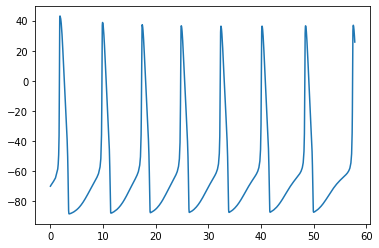

In [132]:
plt.plot(sol.t[0:1500], sol.y[0][0:1500])

In [133]:
from scipy.integrate import solve_ivp
## Simulation of the model in current-clamp mode

## Definition of reversal potential values. 
VNa = 45.; # Sodium reversal potential
VCa = 120.; # Calcium reversal potential
VK = -90.; # Potassium reversal potential
VH= -43.; # Reversal potential for the H-current (permeable to both sodium and potassium ions)
Vleak = -55.; # Reversal potential of leak channels

## Definition of membrane capacitance and maximal conductance values. 
C=0.1; # Membrane capacitance
gLeak=0.1; # Leak current maximal conductance

gNa=120.; # Sodium current maximal conductance 120
gKd=80; # Delayed-rectifier potassium current maximal conductance 80
gT=0; # T-type calcium current maximal conductance 2.
gH=0; # H-current maximal conductance 0.1
gL=0.4; # L-type calcium current maximal conductance 0.4
gKCa=2.; # Calcium-activated potassium current maximal conductance 2.
gA=0.; # A-type potassium current maximal conductance
gKir=0.; # Inward-rectifier potassium current maximal conductance

## Definition of simulation time.
Tfinal=50.0
tspan=[0.0,Tfinal]

## Input current defition
# Constant current
Iapp=-1

# Current pulses
I1=0. # Amplitude of first pulse
ti1=100 # Starting time of first pulse
tf1=103 # Ending time of first pulse
I2=0. # Amplitude of second pulse
ti2=200 # Starting time of second pulse
tf2=203 # Ending time of first pulse

# Sinusoidal input
Ain=0.0 # Amplitude
Win=0.0 # Frequency

#Hyperparameters
gamma=5
alpha=0.5

# Input noise
NoiseIN=0. # Amplitude
TauNoise=2.0 # Cut-off frequency

## Current-clamp experiment
# Parameter vector for simulations
p=[Iapp,I1,I2,ti1,tf1,ti2,tf2,gT,gKd,gH,gNa,gA,gKir,gLeak,gL,gKCa,C,NoiseIN,TauNoise,Ain,Win]

# Initial conditions
V0= -70.
x0 = [V0,mNa_inf(V0),hNa_inf(V0),mH_inf(V0),mt_inf(V0),ht_inf(V0) ,mA_inf(V0), hA_inf(V0), mKd_inf(V0), mL_inf(V0), -10*gL*mL_inf(V0)*(V0-VCa), 0.0]

Theta0=(np.array([20,20,20,20,0,0,20,20,20])).tolist()
A0=(np.ones(num_Theta)*0.1).tolist()
P0=(np.identity(num_Theta)*0.1).flatten().tolist()
X0_=[*x0,*Theta0,*A0,*P0,*x0]
print(len(X0_))
print(len(Theta0))

[ 6.74512312 13.50533026 12.70809172 14.20681027  6.64069228  1.4762776
 14.50021052 16.3773443  17.4347658 ]
123
9


In [124]:
print(variable_size)

[12, 9, 9, 81, 12]


In [125]:
# Simulation
#prob = SDEProblem(HM_ODE,σ_HM,x0,tspan,p) # Simulation with noise (SDE)
sol=solve_ivp(OB_ODE2 ,tspan , X0_, 'BDF')

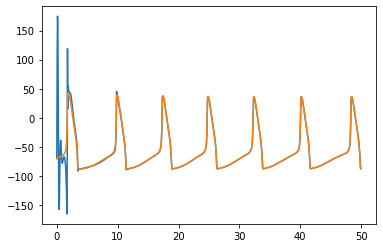

In [126]:
plt.plot(sol.t,sol.y[0])
plt.plot(sol.t,sol.y[111])

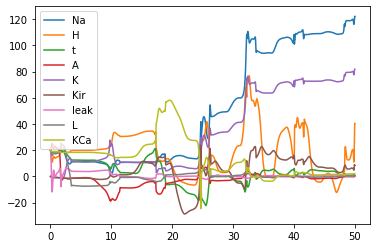

In [127]:
labels=[ 'Na','H','t','A','K','Kir','leak','L','KCa']
plt.figure()
for i in range(num_Theta):
    plt.plot(sol.t,sol.y[12+i],label=labels[i])
plt.legend()
plt.show()

In [113]:
print(sol.y[12:12+num_Theta,-1])

[ 1.22290062e+02  4.04595603e+01  8.52967327e-01  2.14724665e-01
  8.18862091e+01  8.24994879e+00 -6.39300018e-02  3.29190262e-01
  2.08917906e+00]


In [10]:
data = [123,452,342,533,222,402,124,125,263,254,44,987,78,655,741,165,597,26,15,799,100,154,122,563] 
sizes = [2, 5, 14, 3]
it = iter(data)
a=[[next(it) for _ in range(size)] for size in sizes]


[123, 452]